# Parameter Tuning Analysis - Cross-Asset Lead-Lag Strategy

**Objective:** Analyze hyperparameter sweep results to identify optimal and robust configurations.

**Metrics:**
- Primary: Sharpe Ratio (risk-adjusted returns)
- Secondary: Max Drawdown, Win Rate, Total Return
- Robustness Score: `Sharpe_mean - 0.5 × Sharpe_std`

**Author:** Quantitative Development Team  
**Date:** 2025

In [53]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load Tuning Results

In [54]:
# Load results
results_file = 'tuning_results.csv'

if not Path(results_file).exists():
    raise FileNotFoundError(f"❌ {results_file} not found. Run tuner.py first!")

df = pd.read_csv(results_file)

print(f"✓ Loaded {len(df)} tuning results")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Display first few rows
df.head()

✓ Loaded 54 tuning results

Dataset shape: (54, 19)

Columns: ['interval', 'window', 'z_entry', 'z_exit', 'pair_category', 'leader', 'lagger', 'lag', 'base_correlation', 'max_correlation', 'sharpe_ratio', 'max_drawdown', 'max_drawdown_pct', 'total_return_pct', 'num_trades', 'win_rate', 'sortino_ratio', 'final_capital', 'volatility_annual']


,interval,window,z_entry,z_exit,pair_category,leader,lagger,lag,base_correlation,max_correlation,sharpe_ratio,max_drawdown,max_drawdown_pct,total_return_pct,num_trades,win_rate,sortino_ratio,final_capital,volatility_annual
0,1h,60,1.5000,0.3000,Crypto-Crypto,BTCUSDT,ETHUSDT,0,0.8285,0.8285,-34.9796,-0.5512,-55.1189,-50.6183,40,0.4000,-16.2040,49381.6874,5.9317
1,1h,60,1.5000,0.3000,Crypto-Crypto,ETHUSDT,SOLUSDT,0,0.8084,0.8084,-25.2511,-0.3825,-38.2521,-36.9793,42,0.2381,-17.5969,63020.7117,5.3252
2,1h,60,1.5000,0.3000,Crypto-Crypto,BTCUSDT,SOLUSDT,0,0.7871,0.7871,-32.1888,-0.5317,-53.1737,-46.5219,44,0.3636,-15.1374,53478.0528,5.6948
3,1h,60,1.5000,0.5000,Crypto-Crypto,BTCUSDT,ETHUSDT,0,0.8285,0.8285,-35.0615,-0.5437,-54.3747,-49.8579,42,0.4286,-15.0519,50142.0645,5.7997
4,1h,60,1.5000,0.5000,Crypto-Crypto,ETHUSDT,SOLUSDT,0,0.8084,0.8084,-44.2584,-0.4885,-48.8486,-46.5038,42,0.1905,-23.3825,53496.1800,4.3302


In [55]:
# Basic statistics
print("📊 DATASET OVERVIEW\n" + "="*60)
print(f"Total configurations tested: {len(df)}")
print(f"Unique parameter combinations: {df[['interval', 'window', 'z_entry', 'z_exit']].drop_duplicates().shape[0]}")
print(f"Pairs tested: {df[['leader', 'lagger']].drop_duplicates().shape[0]}")
print(f"\nParameter ranges:")
print(f"  Intervals: {sorted(df['interval'].unique())}")
print(f"  Windows: {sorted(df['window'].unique())}")
print(f"  Z-Entry: {sorted(df['z_entry'].unique())}")
print(f"  Z-Exit: {sorted(df['z_exit'].unique())}")

📊 DATASET OVERVIEW
Total configurations tested: 54
Unique parameter combinations: 18
Pairs tested: 3

Parameter ranges:
  Intervals: ['1h']
  Windows: [np.int64(60), np.int64(90), np.int64(120)]
  Z-Entry: [np.float64(1.5), np.float64(2.0), np.float64(2.5)]
  Z-Exit: [np.float64(0.3), np.float64(0.5)]


In [56]:
# Performance distribution
print("\n📈 PERFORMANCE METRICS DISTRIBUTION\n" + "="*60)
print(df[['sharpe_ratio', 'total_return_pct', 'max_drawdown_pct', 'win_rate', 'num_trades']].describe())


📈 PERFORMANCE METRICS DISTRIBUTION
       sharpe_ratio  total_return_pct  max_drawdown_pct  win_rate  num_trades
count       54.0000           54.0000           54.0000   54.0000     54.0000
mean       -21.1891          -28.1994          -34.0216    0.2695     17.9259
std         16.7993           18.3005           13.7951    0.1676     11.9335
min        -44.2584          -54.3368          -55.1189    0.0000      4.0000
25%        -30.1932          -38.7456          -40.6809    0.1929      8.5000
50%        -24.8656          -33.3563          -34.6887    0.3000     14.0000
75%        -17.6791          -14.7331          -27.2299    0.3333     27.0000
max         45.0514           25.2559           -2.4581    0.7500     44.0000


## 2. Parameter-wise Analysis

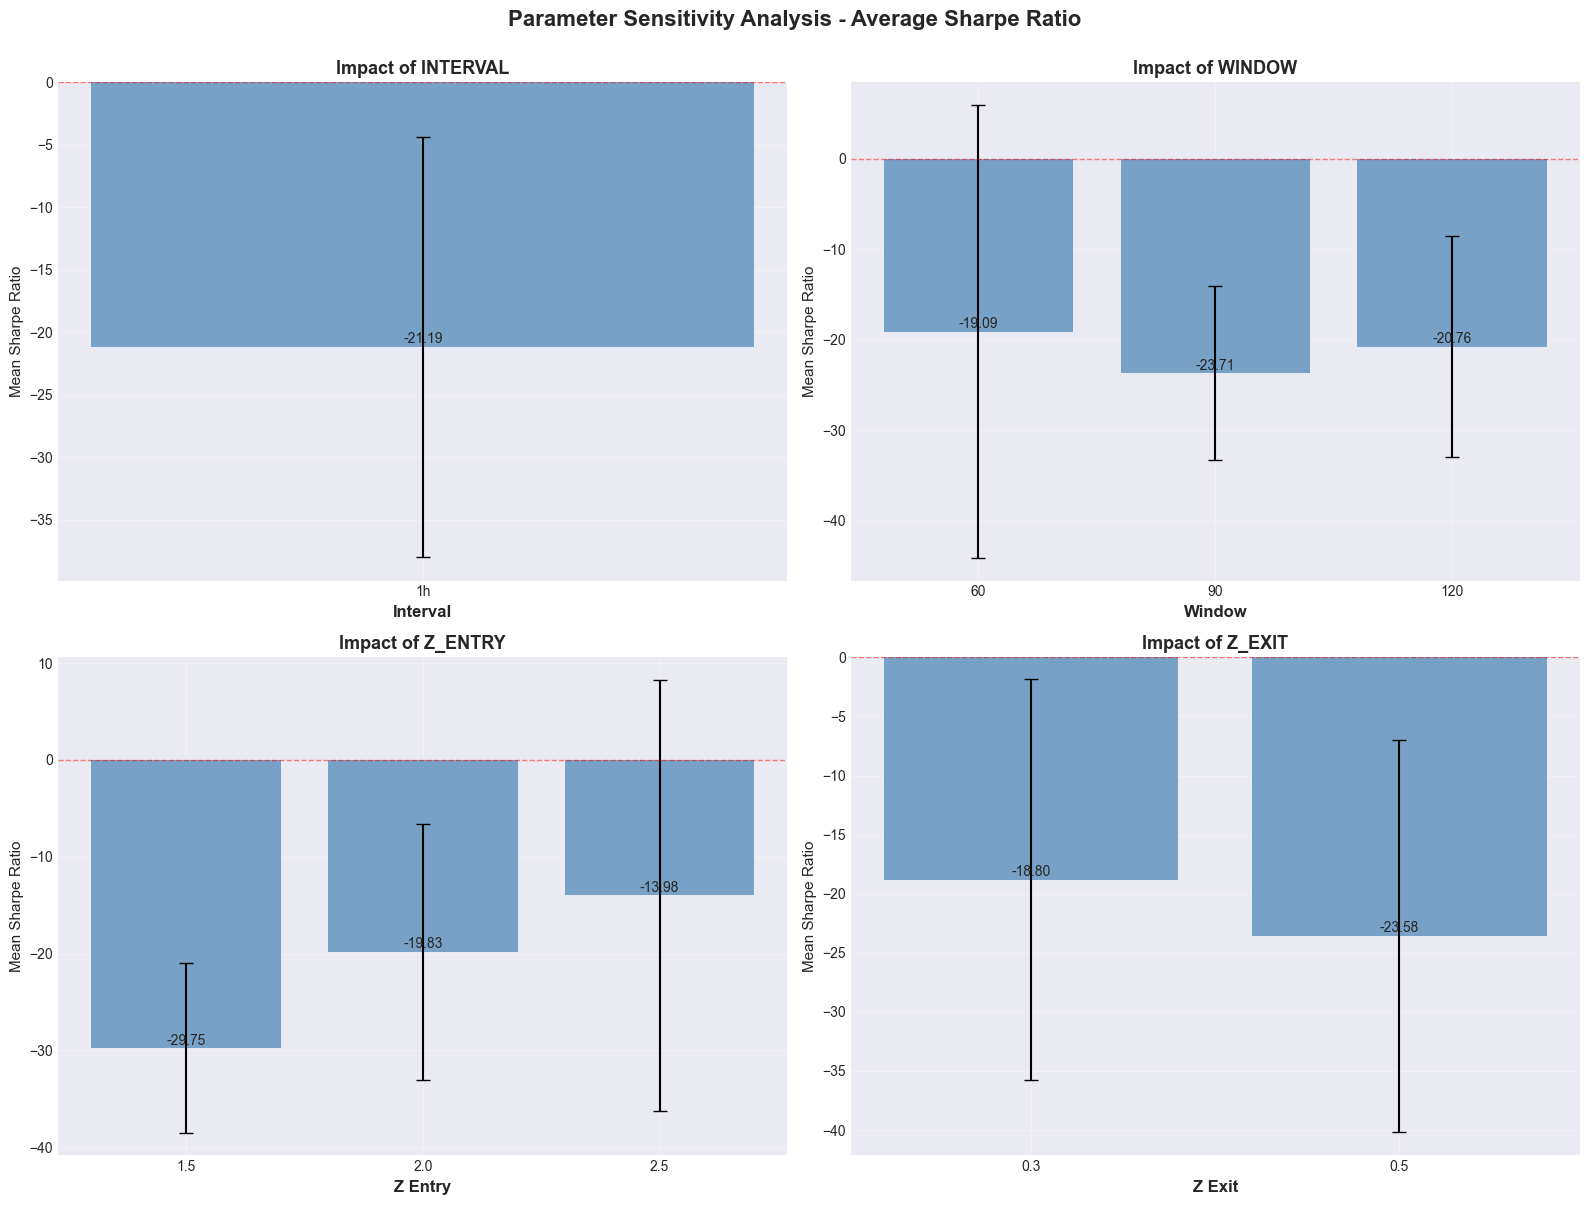

✓ Saved: sensitivity_analysis.png


In [57]:
# Analyze each parameter's impact
parameters = ['interval', 'window', 'z_entry', 'z_exit']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, param in enumerate(parameters):
    ax = axes[idx]
    
    # Group by parameter
    grouped = df.groupby(param)['sharpe_ratio'].agg(['mean', 'std', 'count'])
    
    # Plot
    x = grouped.index.astype(str)
    y = grouped['mean']
    yerr = grouped['std']
    
    ax.bar(x, y, yerr=yerr, capsize=5, alpha=0.7, color='steelblue')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel(param.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Sharpe Ratio', fontsize=11)
    ax.set_title(f'Impact of {param.upper()}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(i, yi + 0.05, f'{yi:.2f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Parameter Sensitivity Analysis - Average Sharpe Ratio', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('sensitivity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: sensitivity_analysis.png")

## 3. Heatmaps - Parameter Interactions

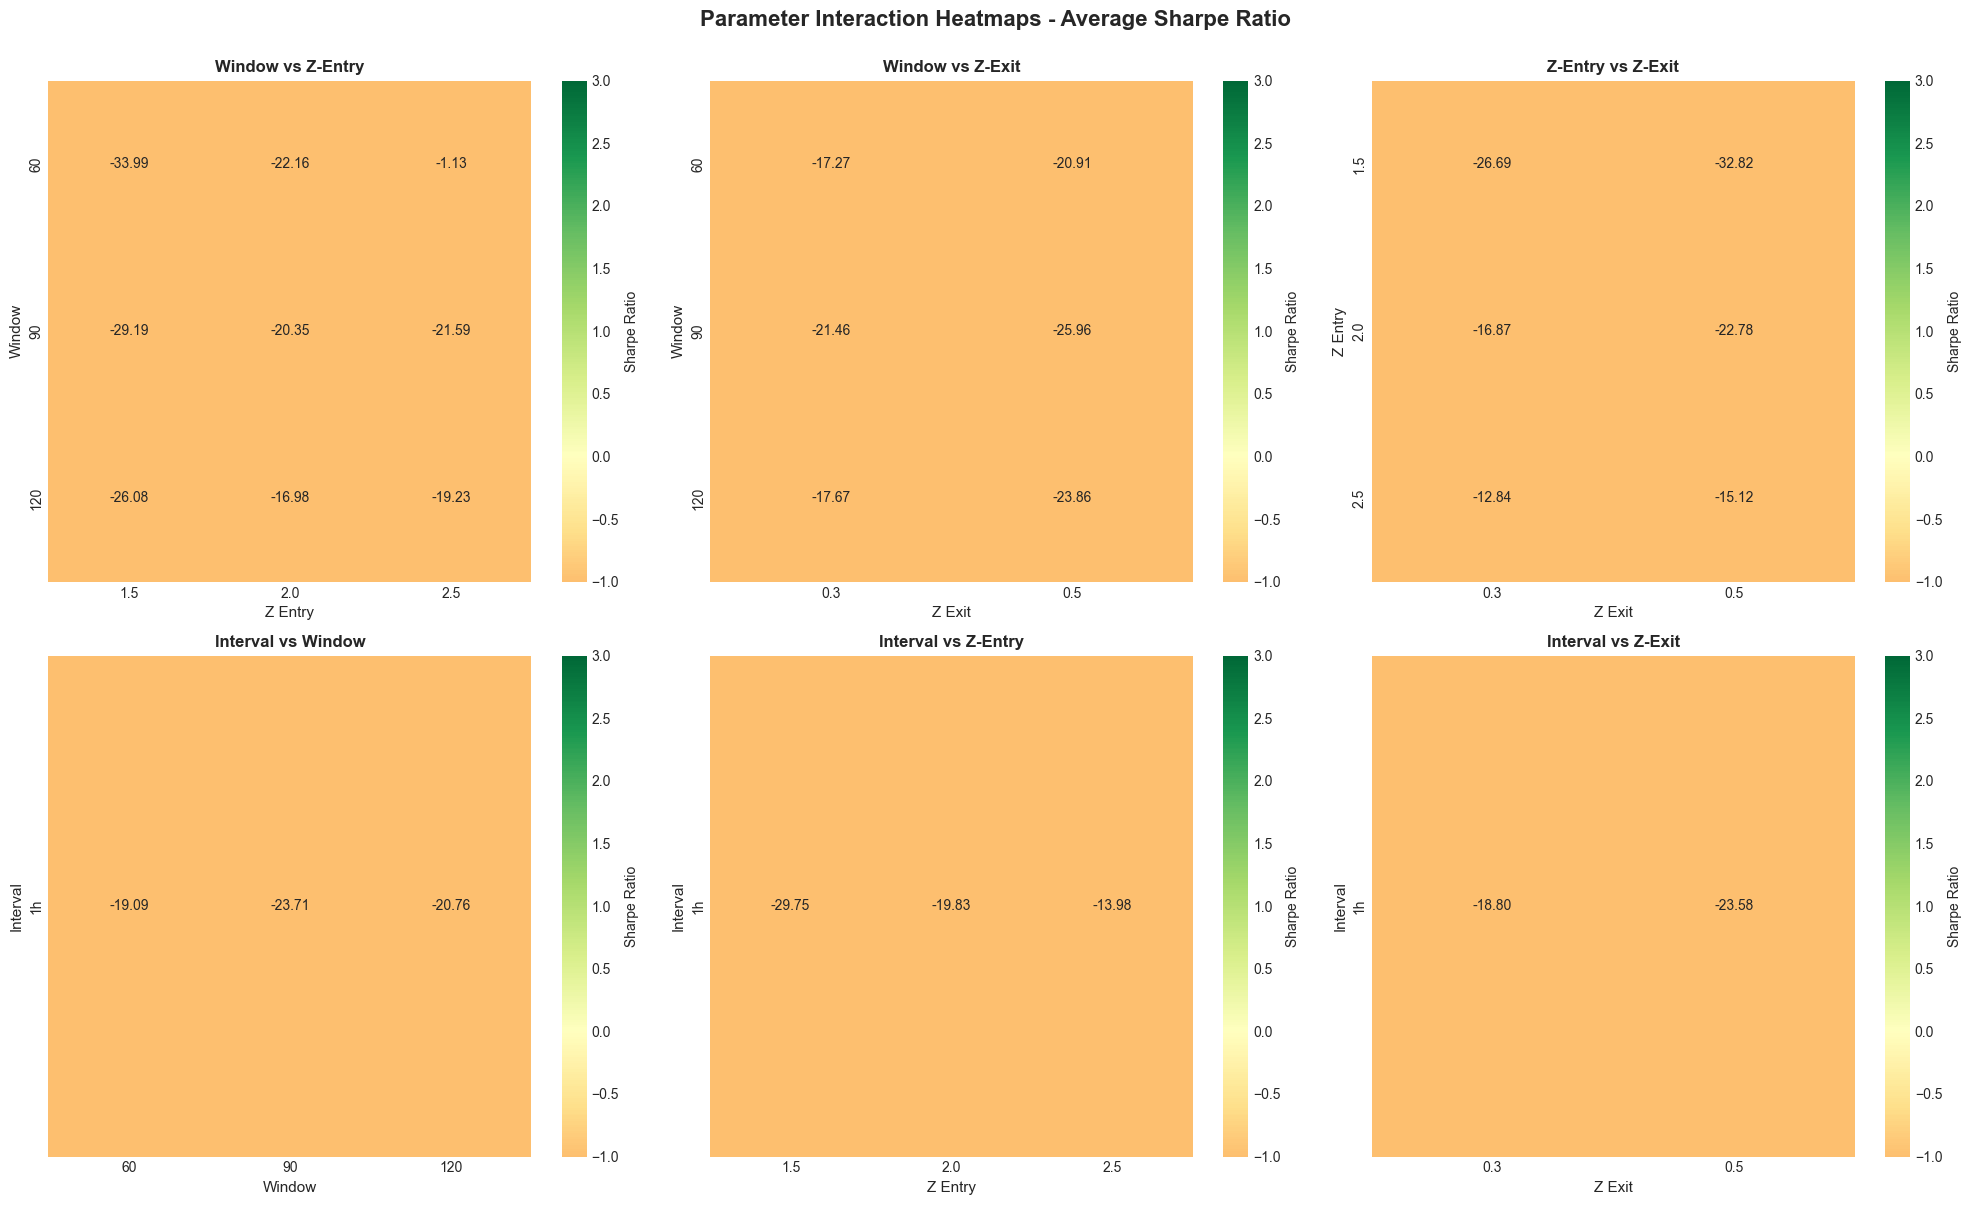

✓ Saved: heatmaps_sharpe.png


In [58]:
# Create heatmaps for key parameter pairs
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Define parameter pairs to visualize
param_pairs = [
    ('window', 'z_entry', 'Window vs Z-Entry'),
    ('window', 'z_exit', 'Window vs Z-Exit'),
    ('z_entry', 'z_exit', 'Z-Entry vs Z-Exit'),
    ('interval', 'window', 'Interval vs Window'),
    ('interval', 'z_entry', 'Interval vs Z-Entry'),
    ('interval', 'z_exit', 'Interval vs Z-Exit'),
]

for idx, (param1, param2, title) in enumerate(param_pairs):
    ax = axes[idx // 3, idx % 3]
    
    # Create pivot table
    pivot = df.pivot_table(
        values='sharpe_ratio',
        index=param1,
        columns=param2,
        aggfunc='mean'
    )
    
    # Plot heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        center=0,
        cbar_kws={'label': 'Sharpe Ratio'},
        ax=ax,
        vmin=-1,
        vmax=3
    )
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(param2.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel(param1.replace('_', ' ').title(), fontsize=11)

plt.suptitle('Parameter Interaction Heatmaps - Average Sharpe Ratio',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('heatmaps_sharpe.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: heatmaps_sharpe.png")

## 4. Multi-Metric Heatmap (Window vs Z-Entry)

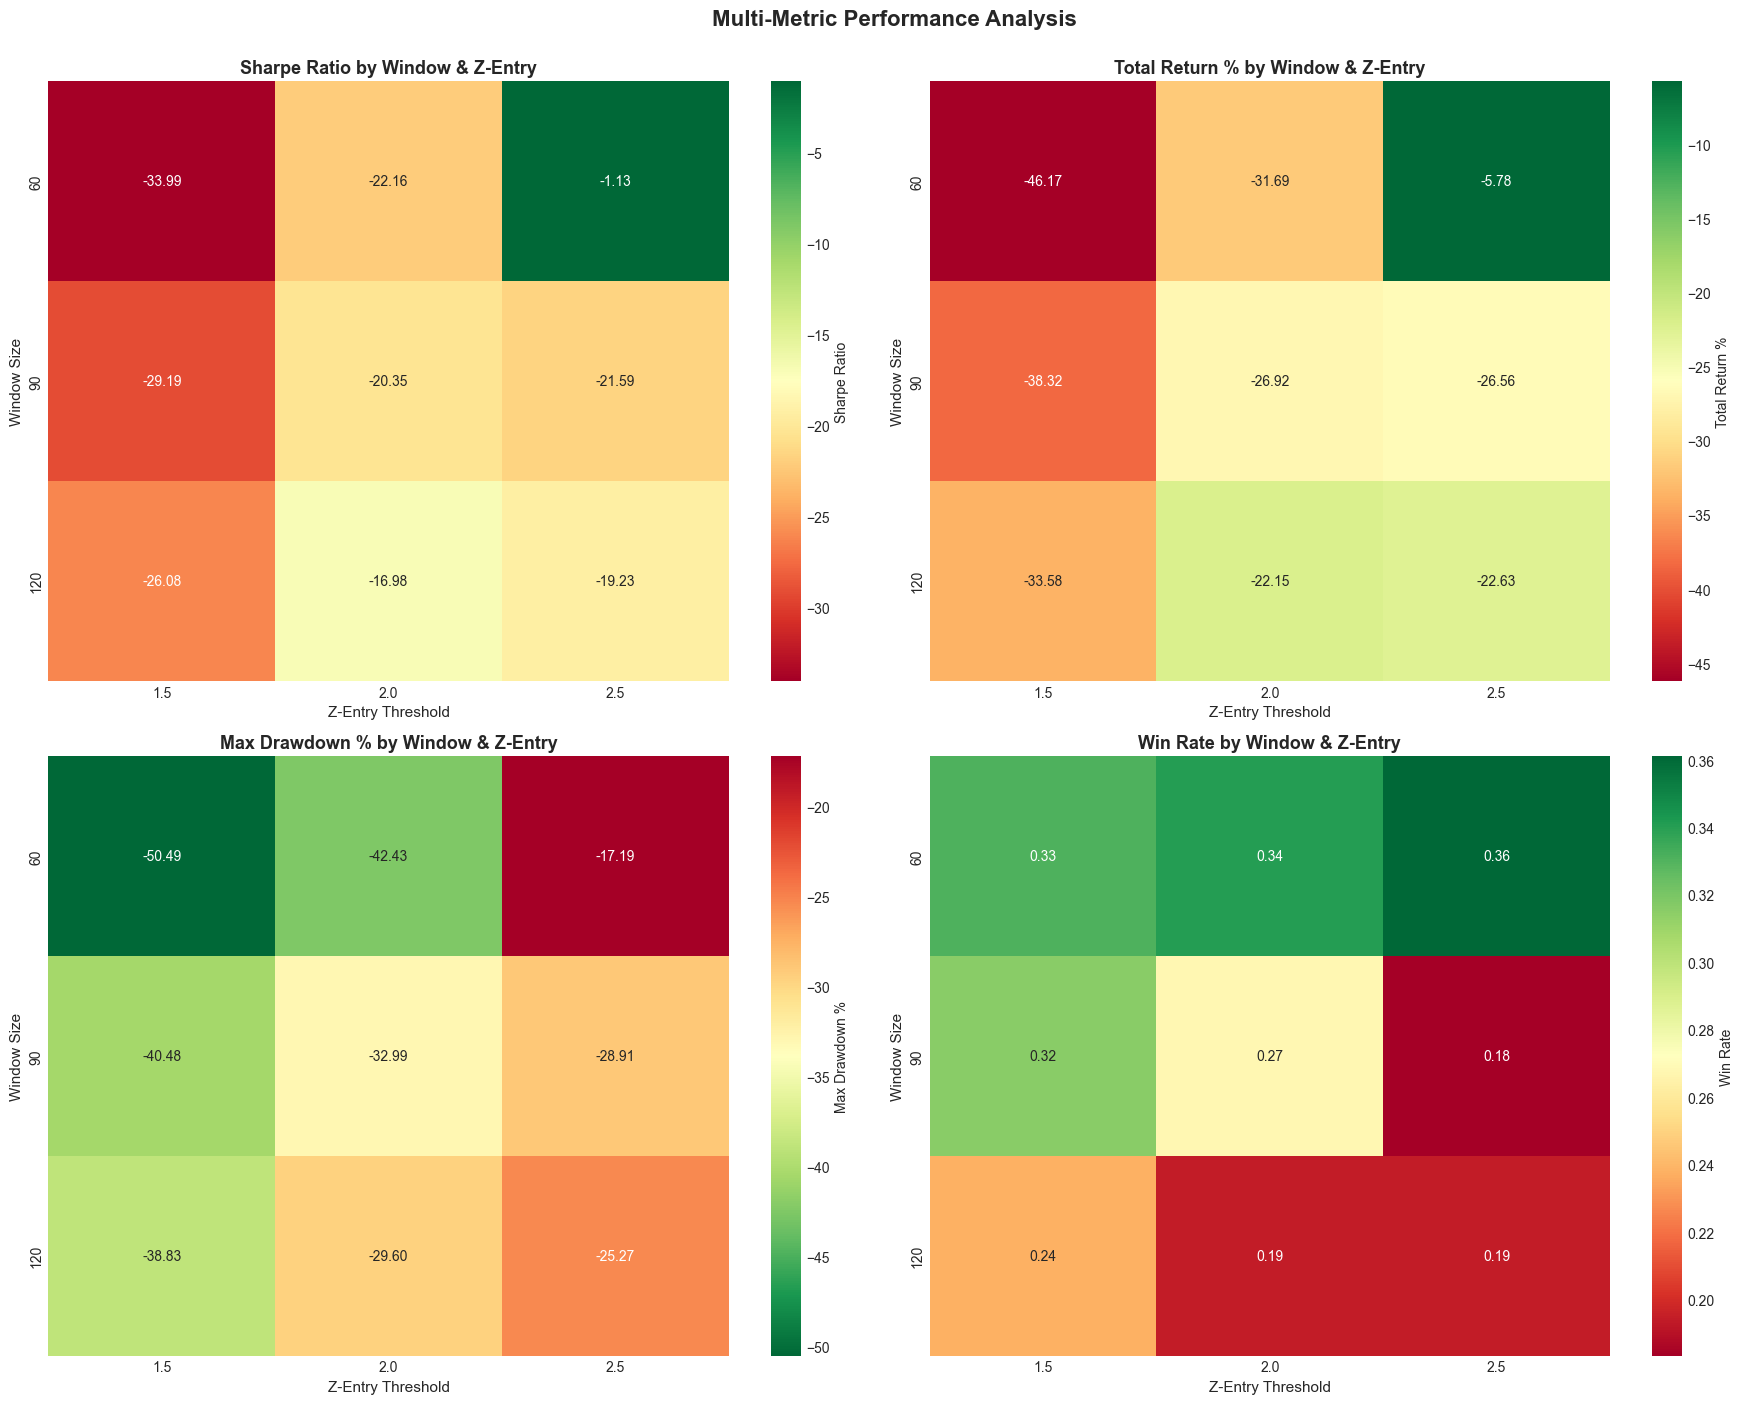

✓ Saved: heatmaps_multi_metric.png


In [59]:
# Create multi-metric comparison
metrics = ['sharpe_ratio', 'total_return_pct', 'max_drawdown_pct', 'win_rate']
metric_names = ['Sharpe Ratio', 'Total Return %', 'Max Drawdown %', 'Win Rate']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    
    # Create pivot table
    pivot = df.pivot_table(
        values=metric,
        index='window',
        columns='z_entry',
        aggfunc='mean'
    )
    
    # Choose colormap based on metric
    if 'drawdown' in metric:
        cmap = 'RdYlGn_r'  # Reverse for drawdown (lower is better)
    else:
        cmap = 'RdYlGn'
    
    # Plot heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap=cmap,
        cbar_kws={'label': name},
        ax=ax
    )
    
    ax.set_title(f'{name} by Window & Z-Entry', fontsize=13, fontweight='bold')
    ax.set_xlabel('Z-Entry Threshold', fontsize=11)
    ax.set_ylabel('Window Size', fontsize=11)

plt.suptitle('Multi-Metric Performance Analysis',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('heatmaps_multi_metric.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: heatmaps_multi_metric.png")

## 5. Robustness Analysis

**Robustness Score:** `mean(Sharpe) - 0.5 × std(Sharpe)`

This penalizes configurations with high variance across different pairs/conditions.

In [60]:
# Calculate robustness score for each parameter combination
robustness_df = df.groupby(['interval', 'window', 'z_entry', 'z_exit']).agg({
    'sharpe_ratio': ['mean', 'std', 'count', 'min', 'max'],
    'total_return_pct': 'mean',
    'max_drawdown_pct': 'mean',
    'win_rate': 'mean',
    'num_trades': 'mean'
}).reset_index()

# Flatten column names
robustness_df.columns = ['_'.join(col).strip('_') for col in robustness_df.columns.values]
robustness_df.columns = ['interval', 'window', 'z_entry', 'z_exit', 
                         'sharpe_mean', 'sharpe_std', 'sharpe_count', 'sharpe_min', 'sharpe_max',
                         'return_mean', 'drawdown_mean', 'winrate_mean', 'trades_mean']

# Calculate robustness score
robustness_df['robustness_score'] = robustness_df['sharpe_mean'] - 0.5 * robustness_df['sharpe_std']

# Sort by robustness score
robustness_df = robustness_df.sort_values('robustness_score', ascending=False)

print("\n📊 ROBUSTNESS ANALYSIS\n" + "="*80)
print("\nTop 10 Most Robust Configurations:")
print(robustness_df.head(10)[[
    'interval', 'window', 'z_entry', 'z_exit',
    'sharpe_mean', 'sharpe_std', 'robustness_score',
    'return_mean', 'drawdown_mean', 'winrate_mean', 'trades_mean'
]].to_string(index=False))


📊 ROBUSTNESS ANALYSIS

Top 10 Most Robust Configurations:
interval  window  z_entry  z_exit  sharpe_mean  sharpe_std  robustness_score  return_mean  drawdown_mean  winrate_mean  trades_mean
      1h      60   2.5000  0.5000      -0.7552     40.0621          -20.7862      -5.5650       -17.0286        0.3611       8.0000
      1h      60   2.5000  0.3000      -1.5061     38.7746          -20.8934      -5.9898       -17.3593        0.3611       8.0000
      1h     120   2.0000  0.3000     -12.6192     19.7505          -22.4944     -18.4893       -28.9733        0.2222      10.0000
      1h      90   2.5000  0.3000     -18.3460      9.4793          -23.0857     -25.2200       -29.8789        0.2444       8.6667
      1h     120   2.5000  0.3000     -18.6781      9.8670          -23.6116     -22.1731       -25.2539        0.2778       5.3333
      1h     120   2.5000  0.5000     -19.7919     10.0549          -24.8193     -23.0904       -25.2915        0.1111       5.3333
      1h      90 

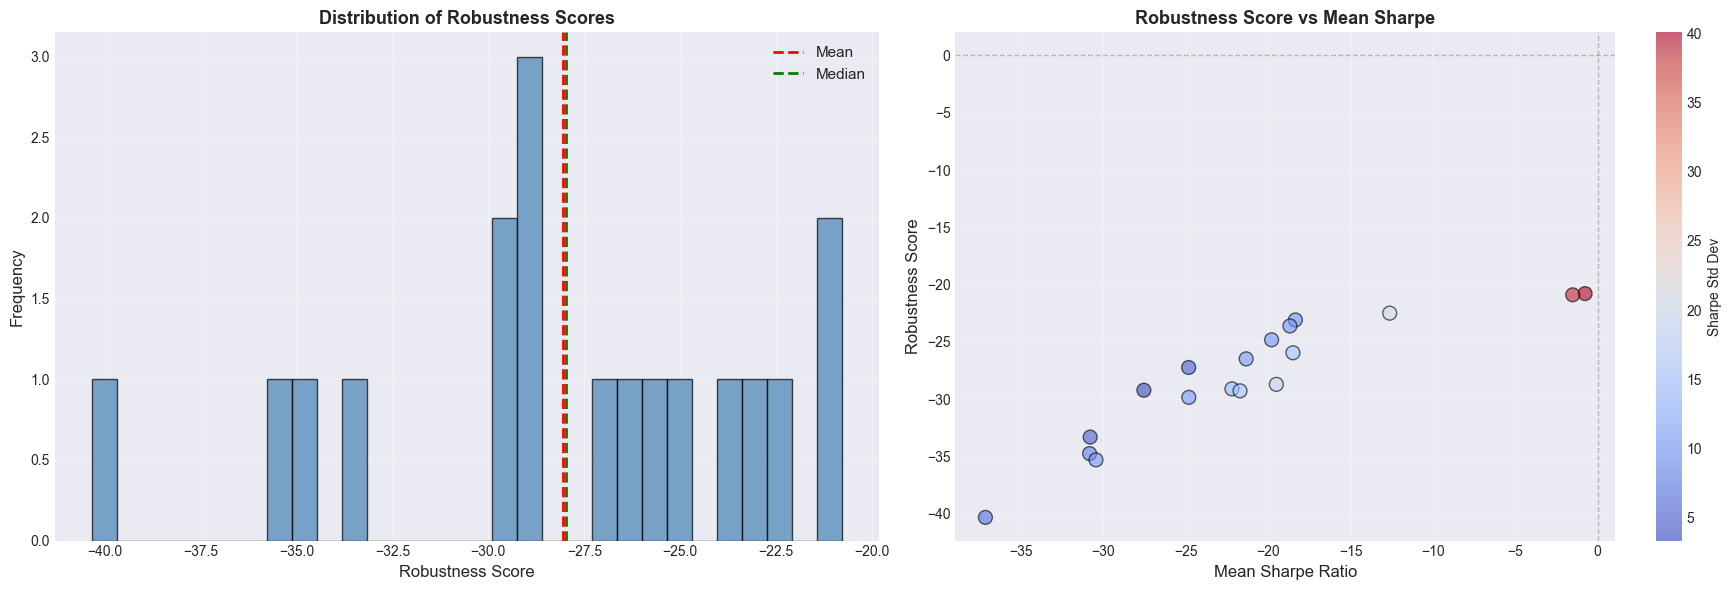

✓ Saved: robustness_analysis.png


In [61]:
# Visualize robustness score vs raw Sharpe
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Robustness score distribution
ax1 = axes[0]
ax1.hist(robustness_df['robustness_score'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(robustness_df['robustness_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax1.axvline(robustness_df['robustness_score'].median(), color='green', linestyle='--', linewidth=2, label='Median')
ax1.set_xlabel('Robustness Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Robustness Scores', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Robustness vs mean Sharpe
ax2 = axes[1]
scatter = ax2.scatter(
    robustness_df['sharpe_mean'],
    robustness_df['robustness_score'],
    c=robustness_df['sharpe_std'],
    cmap='coolwarm',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
plt.colorbar(scatter, ax=ax2, label='Sharpe Std Dev')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Mean Sharpe Ratio', fontsize=12)
ax2.set_ylabel('Robustness Score', fontsize=12)
ax2.set_title('Robustness Score vs Mean Sharpe', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: robustness_analysis.png")

## 6. Top 5 Configurations - Detailed Analysis

In [62]:
# Get top 5 by different criteria
print("\n🏆 TOP 5 CONFIGURATIONS\n" + "="*80)

print("\n1️⃣  By Robustness Score:")
print("="*80)
top5_robust = robustness_df.head(5)
print(top5_robust[[
    'interval', 'window', 'z_entry', 'z_exit',
    'robustness_score', 'sharpe_mean', 'sharpe_std', 'sharpe_count',
    'return_mean', 'drawdown_mean', 'winrate_mean'
]].to_string(index=False))

print("\n\n2️⃣  By Mean Sharpe Ratio:")
print("="*80)
top5_sharpe = robustness_df.nlargest(5, 'sharpe_mean')
print(top5_sharpe[[
    'interval', 'window', 'z_entry', 'z_exit',
    'sharpe_mean', 'sharpe_std', 'robustness_score',
    'return_mean', 'drawdown_mean', 'winrate_mean'
]].to_string(index=False))

print("\n\n3️⃣  By Total Return:")
print("="*80)
top5_return = robustness_df.nlargest(5, 'return_mean')
print(top5_return[[
    'interval', 'window', 'z_entry', 'z_exit',
    'return_mean', 'sharpe_mean', 'drawdown_mean',
    'winrate_mean', 'robustness_score'
]].to_string(index=False))


🏆 TOP 5 CONFIGURATIONS

1️⃣  By Robustness Score:
interval  window  z_entry  z_exit  robustness_score  sharpe_mean  sharpe_std  sharpe_count  return_mean  drawdown_mean  winrate_mean
      1h      60   2.5000  0.5000          -20.7862      -0.7552     40.0621             3      -5.5650       -17.0286        0.3611
      1h      60   2.5000  0.3000          -20.8934      -1.5061     38.7746             3      -5.9898       -17.3593        0.3611
      1h     120   2.0000  0.3000          -22.4944     -12.6192     19.7505             3     -18.4893       -28.9733        0.2222
      1h      90   2.5000  0.3000          -23.0857     -18.3460      9.4793             3     -25.2200       -29.8789        0.2444
      1h     120   2.5000  0.3000          -23.6116     -18.6781      9.8670             3     -22.1731       -25.2539        0.2778


2️⃣  By Mean Sharpe Ratio:
interval  window  z_entry  z_exit  sharpe_mean  sharpe_std  robustness_score  return_mean  drawdown_mean  winrate_mean
   

## 7. Performance by Pair Category

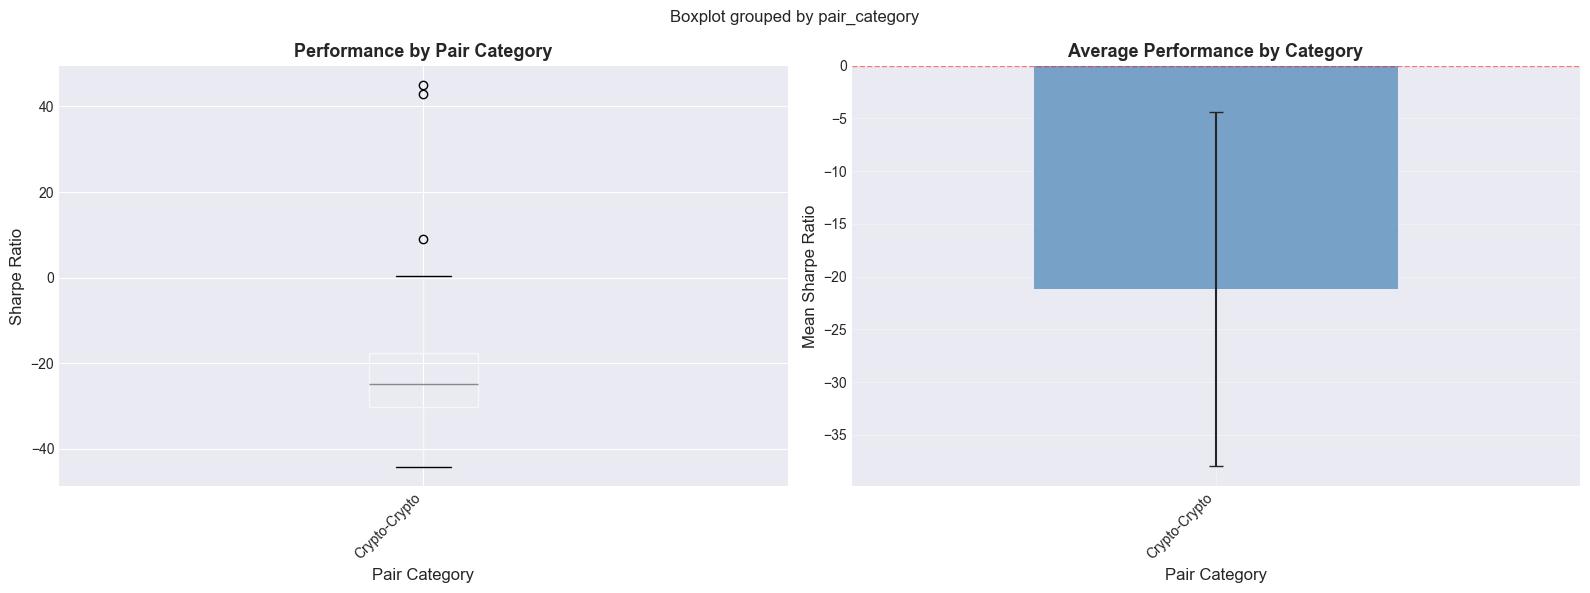

✓ Saved: performance_by_category.png

📊 Category Statistics:
                  mean     std  count
pair_category                        
Crypto-Crypto -21.1891 16.7993     54


In [63]:
# Analyze performance by pair category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot by category
ax1 = axes[0]
df.boxplot(column='sharpe_ratio', by='pair_category', ax=ax1)
ax1.set_xlabel('Pair Category', fontsize=12)
ax1.set_ylabel('Sharpe Ratio', fontsize=12)
ax1.set_title('Performance by Pair Category', fontsize=13, fontweight='bold')
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')

# Bar chart - mean performance
ax2 = axes[1]
category_stats = df.groupby('pair_category')['sharpe_ratio'].agg(['mean', 'std', 'count'])
category_stats['mean'].plot(kind='bar', yerr=category_stats['std'], capsize=5, ax=ax2, color='steelblue', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Pair Category', fontsize=12)
ax2.set_ylabel('Mean Sharpe Ratio', fontsize=12)
ax2.set_title('Average Performance by Category', fontsize=13, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: performance_by_category.png")

print("\n📊 Category Statistics:")
print(category_stats)

## 8. Recommendation Engine

In [64]:
# Generate final recommendation
print("\n" + "="*80)
print("🎯 FINAL RECOMMENDATIONS")
print("="*80)

# Best overall configuration
best_config = robustness_df.iloc[0]

print("\n✨ RECOMMENDED CONFIGURATION (Most Robust):")
print("─"*80)
print(f"  Interval:     {best_config['interval']}")
print(f"  Window:       {int(best_config['window'])}")
print(f"  Z-Entry:      {best_config['z_entry']:.1f}")
print(f"  Z-Exit:       {best_config['z_exit']:.1f}")
print("\n📊 Expected Performance:")
print(f"  Sharpe Ratio:       {best_config['sharpe_mean']:.2f} ± {best_config['sharpe_std']:.2f}")
print(f"  Robustness Score:   {best_config['robustness_score']:.2f}")
print(f"  Total Return:       {best_config['return_mean']:.2f}%")
print(f"  Max Drawdown:       {best_config['drawdown_mean']:.2f}%")
print(f"  Win Rate:           {best_config['winrate_mean']*100:.1f}%")
print(f"  Avg Trades:         {best_config['trades_mean']:.0f}")
print(f"  Tested on:          {int(best_config['sharpe_count'])} pairs")

# Alternative configurations
print("\n\n🔄 ALTERNATIVE CONFIGURATIONS:")
print("─"*80)

for idx, row in robustness_df.iloc[1:4].iterrows():
    print(f"\nOption {idx}:")
    print(f"  Config: interval={row['interval']}, window={int(row['window'])}, "
          f"z_entry={row['z_entry']:.1f}, z_exit={row['z_exit']:.1f}")
    print(f"  Sharpe: {row['sharpe_mean']:.2f}, Robustness: {row['robustness_score']:.2f}, "
          f"Return: {row['return_mean']:.2f}%, DrawDown: {row['drawdown_mean']:.2f}%")

# Insights
print("\n\n💡 KEY INSIGHTS:")
print("─"*80)

# Best interval
interval_perf = robustness_df.groupby('interval')['robustness_score'].mean().sort_values(ascending=False)
print(f"✓ Best interval: {interval_perf.index[0]} (avg robustness: {interval_perf.iloc[0]:.2f})")

# Best window
window_perf = robustness_df.groupby('window')['robustness_score'].mean().sort_values(ascending=False)
print(f"✓ Best window: {int(window_perf.index[0])} (avg robustness: {window_perf.iloc[0]:.2f})")

# Best z_entry
zentry_perf = robustness_df.groupby('z_entry')['robustness_score'].mean().sort_values(ascending=False)
print(f"✓ Best z_entry: {zentry_perf.index[0]:.1f} (avg robustness: {zentry_perf.iloc[0]:.2f})")

# Best z_exit
zexit_perf = robustness_df.groupby('z_exit')['robustness_score'].mean().sort_values(ascending=False)
print(f"✓ Best z_exit: {zexit_perf.index[0]:.1f} (avg robustness: {zexit_perf.iloc[0]:.2f})")

print("\n" + "="*80)


🎯 FINAL RECOMMENDATIONS

✨ RECOMMENDED CONFIGURATION (Most Robust):
────────────────────────────────────────────────────────────────────────────────
  Interval:     1h
  Window:       60
  Z-Entry:      2.5
  Z-Exit:       0.5

📊 Expected Performance:
  Sharpe Ratio:       -0.76 ± 40.06
  Robustness Score:   -20.79
  Total Return:       -5.57%
  Max Drawdown:       -17.03%
  Win Rate:           36.1%
  Avg Trades:         8
  Tested on:          3 pairs


🔄 ALTERNATIVE CONFIGURATIONS:
────────────────────────────────────────────────────────────────────────────────

Option 4:
  Config: interval=1h, window=60, z_entry=2.5, z_exit=0.3
  Sharpe: -1.51, Robustness: -20.89, Return: -5.99%, DrawDown: -17.36%

Option 14:
  Config: interval=1h, window=120, z_entry=2.0, z_exit=0.3
  Sharpe: -12.62, Robustness: -22.49, Return: -18.49%, DrawDown: -28.97%

Option 10:
  Config: interval=1h, window=90, z_entry=2.5, z_exit=0.3
  Sharpe: -18.35, Robustness: -23.09, Return: -25.22%, DrawDown: -29.88%



## 9. Export Summary Report

In [65]:
# Save top configurations to CSV
output_file = 'top_configurations.csv'
robustness_df.head(10).to_csv(output_file, index=False)
print(f"✓ Saved top 10 configurations to: {output_file}")

# Generate summary statistics file
summary_stats = {
    'total_configs_tested': len(df),
    'unique_param_combinations': len(robustness_df),
    'best_interval': interval_perf.index[0],
    'best_window': int(window_perf.index[0]),
    'best_z_entry': float(zentry_perf.index[0]),
    'best_z_exit': float(zexit_perf.index[0]),
    'recommended_sharpe': float(best_config['sharpe_mean']),
    'recommended_robustness': float(best_config['robustness_score']),
    'recommended_return': float(best_config['return_mean']),
    'recommended_drawdown': float(best_config['drawdown_mean']),
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('tuning_summary.csv', index=False)
print(f"✓ Saved summary statistics to: tuning_summary.csv")

✓ Saved top 10 configurations to: top_configurations.csv
✓ Saved summary statistics to: tuning_summary.csv


## 10. Conclusion

**Summary:**
- Completed comprehensive parameter sweep
- Identified optimal configurations based on robustness
- Generated visualizations and sensitivity analysis
- Provided clear recommendations for production deployment

**Next Steps:**
1. Implement recommended configuration in production
2. Monitor performance in paper trading
3. Periodically re-run tuning with new data
4. Consider adaptive parameter adjustment based on market conditions